In [1]:
import pandas as pd
import numpy as np
import re
import warnings
import matplotlib
import matplotlib.pyplot as plt
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
import os

In [2]:
def trim(df):
    df.columns = df.columns.str.strip()
    df = df.drop_duplicates()
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace(' ','_')
    df_obj = df.select_dtypes(['object'])
    df[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())
    print("All column names have been striped, lowered case, replaced space with underscore if any")
    print("Dropped duplicated instances if any")
    print("Categorical instances have been striped")
    return df

pd.set_option('display.max_colwidth', 255)
df =pd.read_csv('mtsamples1.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df = trim(df)

def vc(df, column, r=False):
    vc_df = df.reset_index().groupby([column]).size().to_frame('count')
    vc_df['percentage (%)'] = vc_df['count'].div(sum(vc_df['count'])).mul(100)
    vc_df = vc_df.sort_values(by=['percentage (%)'], ascending=False)
    if r:
        return vc_df
    else:
        print(f'STATUS: Value counts of "{column}"...')
        display(vc_df)

def shape(df,df_name):
    print(f'STATUS: Dimension of "{df_name}" = {df.shape}')

df.head(3)

All column names have been striped, lowered case, replaced space with underscore if any
Dropped duplicated instances if any
Categorical instances have been striped


,description,medical_specialty,sample_name,transcription,keywords
0,A 23-year-old white female presents with complaint of allergies.,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female presents with complaint of allergies. She used to have allergies when she lived in Seattle but she thinks they are worse here. In the past, she has tried Claritin, and Zyrtec. Both worked for short time b...","allergy / immunology, allergic rhinitis, allergies, asthma, nasal sprays, rhinitis, nasal, erythematous, allegra, sprays, allergic,"
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climbing stairs, difficulty with airline seats, tying shoes, used to public seating, and lifting objects off the floor. He exercises three times a week at home and does cardio. He has difficulty walking two b...","bariatrics, laparoscopic gastric bypass, weight loss programs, gastric bypass, atkin's diet, weight watcher's, body weight, laparoscopic gastric, weight loss, pounds, months, weight, laparoscopic, band, loss, diets, overweight, lost"
2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC today. He is a very pleasant gentleman who is 42 years old, 344 pounds. He is 5'9"". He has a BMI of 51. He has been overweight for ten years since the age of 33, at his highest he was 358 pounds, at hi...","bariatrics, laparoscopic gastric bypass, heart attacks, body weight, pulmonary embolism, potential complications, sleep study, weight loss, gastric bypass, anastomosis, loss, sleep, laparoscopic, gastric, bypass, heart, pounds, weight,"


In [3]:
df = df[df['medical_specialty'].isin(['Neurosurgery','ENT - Otolaryngology','Discharge Summary'])]
shape(df,'df')

STATUS: Dimension of "df" = (260, 5)


# <b>1.2 <span style='color:red'>|</span> Word Counts of Each Medical Specialty </b> <a class="anchor" id="1.2"></a>

To query the data, I would like to know how is the size of the dataset and also to rank null values in descending order

In [6]:
medical_specialty_list = [] ; word_count_list =[]
for medical_specialty in df['medical_specialty'].unique():
    df_filter = df.loc[(df['medical_specialty'] == medical_specialty)]
    word_count_temp = df_filter['transcription'].str.split().str.len().sum()
    medical_specialty_list.append(medical_specialty)
    word_count_list.append(word_count_temp)
word_count_df = pd.DataFrame({'Medical Specialty':medical_specialty_list, 'Word Count':word_count_list})
word_count_df['Word Count'] = word_count_df['Word Count'].astype('int')
word_count_df = word_count_df.sort_values('Word Count', ascending=False)
word_count_df.reset_index(drop=True)

,Medical Specialty,Word Count
0,Discharge Summary,43103
1,ENT - Otolaryngology,42032
2,Neurosurgery,31771


In [7]:
total_word_count = df['transcription'].str.split().str.len().sum()
print(f'The word count of all transcription is: {int(total_word_count)}')

The word count of all transcription is: 116906


# <b>1.3 <span style='color:red'>|</span> Sample Size of Each Medical Specialty </b> <a class="anchor" id="1.3"></a>

In [9]:
vc(df, 'medical_specialty')

STATUS: Value counts of "medical_specialty"...


,count,percentage (%)
medical_specialty,,
Discharge Summary,108,41.538462
ENT - Otolaryngology,98,37.692308
Neurosurgery,54,20.769231


# <b>1.4 <span style='color:red'>|</span> General Cleaning </b> <a class="anchor" id="1.4"></a>

In [11]:
# to print data shape
print(f'data shape is: {df.shape}')

# to identify the null values by descending order
df.isnull().sum().sort_values(ascending = False)

data shape is: (260, 5)


keywords             51
transcription         2
description           0
medical_specialty     0
sample_name           0
dtype: int64

One important detail is that I found out there are 2 rows containing no transcription. They should be removed as transcription is our only predictors in this text classification task.

In [13]:
# to remove transcription rows that is empty
df = df[df['transcription'].notna()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 258 entries, 2222 to 3519
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   description        258 non-null    object
 1   medical_specialty  258 non-null    object
 2   sample_name        258 non-null    object
 3   transcription      258 non-null    object
 4   keywords           207 non-null    object
dtypes: object(5)
memory usage: 12.1+ KB


After dropping the null values, there are no null values for the transcription attribute.

In [15]:
# drop redundant columns
df =df.drop(['description','sample_name','keywords'], axis=1)
df.head(2)

,medical_specialty,transcription
2222,Neurosurgery,"TITLE OF OPERATION:, A complex closure and debridement of wound.,INDICATION FOR SURGERY:, The patient is a 26-year-old female with a long history of shunt and hydrocephalus presenting with a draining wound in the right upper quadrant, just below the..."
2223,Neurosurgery,"TITLE OF OPERATION: , Placement of right new ventriculoperitoneal (VP) shunts Strata valve and to removal of right frontal Ommaya reservoir.,INDICATION FOR SURGERY: , The patient is a 2-month-old infant, born premature with intraventricular hemorrhage..."


The target labels (or the topic) is the 'medical_specialty' attribute. Now, let's identify how is the value counts of the target labels, and as well visualise it in a bar chart. In order to visualise in matplotlib, function of flattening list is defined in order to put the target value counts into the matplotlib function.

The target labels is quite balanced

# <b>2.0 <span style='color:red'>|</span> Text Normalisation </b> <a class="anchor" id="2.0"></a>

Data normalisation will be conducted for the trascription. One of the reasons is to convert the transcript into standard format, which important for data extraction later. In this data normalisation task, following task will be executed, which are:
1. Lowe Case
2. Removing punctuation and numbers
3. Tokenisation of the transcription
4. Lemmatisation
5. Remove Stop Words

# <b>2.1 <span style='color:red'>|</span> Lower Case </b> <a class="anchor" id="2.1"></a>

In [21]:
# To convert transcription into lowercase
def lower(df, attribute):
    df.loc[:,attribute] = df[attribute].apply(lambda x : str.lower(x))
    return df
df = lower(df,'transcription')
df.head(3)

,medical_specialty,transcription
2222,Neurosurgery,"title of operation:, a complex closure and debridement of wound.,indication for surgery:, the patient is a 26-year-old female with a long history of shunt and hydrocephalus presenting with a draining wound in the right upper quadrant, just below the..."
2223,Neurosurgery,"title of operation: , placement of right new ventriculoperitoneal (vp) shunts strata valve and to removal of right frontal ommaya reservoir.,indication for surgery: , the patient is a 2-month-old infant, born premature with intraventricular hemorrhage..."
2224,Neurosurgery,"preoperative diagnosis: , aqueductal stenosis.,postoperative diagnosis:, aqueductal stenosis.,title of procedure: ,endoscopic third ventriculostomy.,anesthesia: , general endotracheal tube anesthesia.,devices:, bactiseal ventricular catheter with a..."


# <b>2.2 <span style='color:red'>|</span> Remove Punctuation and Numbers </b> <a class="anchor" id="2.2"></a>

In [23]:
# To remove transcription punctuation and numbers

warnings.filterwarnings('ignore')
def remove_punc_num(df, attribute):
    df.loc[:,attribute] = df[attribute].apply(lambda x : " ".join(re.findall('[\w]+',x)))
    df[attribute] = df[attribute].str.replace('\d+', '')
    return df
df =remove_punc_num(df, 'transcription')
df_no_punc =df.copy()
df.head(3)

<>:5: SyntaxWarning: invalid escape sequence '\w'
<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\w'
<>:6: SyntaxWarning: invalid escape sequence '\d'
C:\Users\MIC LAB\AppData\Local\Temp\ipykernel_12320\3082104392.py:5: SyntaxWarning: invalid escape sequence '\w'
  df.loc[:,attribute] = df[attribute].apply(lambda x : " ".join(re.findall('[\w]+',x)))
C:\Users\MIC LAB\AppData\Local\Temp\ipykernel_12320\3082104392.py:6: SyntaxWarning: invalid escape sequence '\d'
  df[attribute] = df[attribute].str.replace('\d+', '')


,medical_specialty,transcription
2222,Neurosurgery,title of operation a complex closure and debridement of wound indication for surgery the patient is a 26 year old female with a long history of shunt and hydrocephalus presenting with a draining wound in the right upper quadrant just below the costal ...
2223,Neurosurgery,title of operation placement of right new ventriculoperitoneal vp shunts strata valve and to removal of right frontal ommaya reservoir indication for surgery the patient is a 2 month old infant born premature with intraventricular hemorrhage and ommay...
2224,Neurosurgery,preoperative diagnosis aqueductal stenosis postoperative diagnosis aqueductal stenosis title of procedure endoscopic third ventriculostomy anesthesia general endotracheal tube anesthesia devices bactiseal ventricular catheter with an aesculap burr hol...


# <b>2.3 <span style='color:red'>|</span> Tokenisation </b> <a class="anchor" id="2.3"></a>


In [25]:
# to tokenise transcription

# import nltk
tk =WhitespaceTokenizer()
def tokenise(df, attribute):
    df['tokenised'] = df.apply(lambda row: tk.tokenize(str(row[attribute])), axis=1)
    return df
df =tokenise(df, 'transcription')
df_experiment =df.copy()
df.head(3)

,medical_specialty,transcription,tokenised
2222,Neurosurgery,title of operation a complex closure and debridement of wound indication for surgery the patient is a 26 year old female with a long history of shunt and hydrocephalus presenting with a draining wound in the right upper quadrant just below the costal ...,"[title, of, operation, a, complex, closure, and, debridement, of, wound, indication, for, surgery, the, patient, is, a, 26, year, old, female, with, a, long, history, of, shunt, and, hydrocephalus, presenting, with, a, draining, wound, in, the, right,..."
2223,Neurosurgery,title of operation placement of right new ventriculoperitoneal vp shunts strata valve and to removal of right frontal ommaya reservoir indication for surgery the patient is a 2 month old infant born premature with intraventricular hemorrhage and ommay...,"[title, of, operation, placement, of, right, new, ventriculoperitoneal, vp, shunts, strata, valve, and, to, removal, of, right, frontal, ommaya, reservoir, indication, for, surgery, the, patient, is, a, 2, month, old, infant, born, premature, with, in..."
2224,Neurosurgery,preoperative diagnosis aqueductal stenosis postoperative diagnosis aqueductal stenosis title of procedure endoscopic third ventriculostomy anesthesia general endotracheal tube anesthesia devices bactiseal ventricular catheter with an aesculap burr hol...,"[preoperative, diagnosis, aqueductal, stenosis, postoperative, diagnosis, aqueductal, stenosis, title, of, procedure, endoscopic, third, ventriculostomy, anesthesia, general, endotracheal, tube, anesthesia, devices, bactiseal, ventricular, catheter, w..."


# <b>2.4 <span style='color:red'>|</span> Stemming </b> <a class="anchor" id="2.4"></a>

In [27]:
from nltk.stem.snowball import SnowballStemmer
def stemming(df, attribute):
    # Use English stemmer.
    stemmer = SnowballStemmer("english")
    df['stemmed'] = df[attribute].apply(lambda x: [stemmer.stem(y) for y in x]) # Stem every word.
    return df
df =stemming(df_experiment, 'tokenised')
df.head(2)

,medical_specialty,transcription,tokenised,stemmed
2222,Neurosurgery,title of operation a complex closure and debridement of wound indication for surgery the patient is a 26 year old female with a long history of shunt and hydrocephalus presenting with a draining wound in the right upper quadrant just below the costal ...,"[title, of, operation, a, complex, closure, and, debridement, of, wound, indication, for, surgery, the, patient, is, a, 26, year, old, female, with, a, long, history, of, shunt, and, hydrocephalus, presenting, with, a, draining, wound, in, the, right,...","[titl, of, oper, a, complex, closur, and, debrid, of, wound, indic, for, surgeri, the, patient, is, a, 26, year, old, femal, with, a, long, histori, of, shunt, and, hydrocephalus, present, with, a, drain, wound, in, the, right, upper, quadrant, just, ..."
2223,Neurosurgery,title of operation placement of right new ventriculoperitoneal vp shunts strata valve and to removal of right frontal ommaya reservoir indication for surgery the patient is a 2 month old infant born premature with intraventricular hemorrhage and ommay...,"[title, of, operation, placement, of, right, new, ventriculoperitoneal, vp, shunts, strata, valve, and, to, removal, of, right, frontal, ommaya, reservoir, indication, for, surgery, the, patient, is, a, 2, month, old, infant, born, premature, with, in...","[titl, of, oper, placement, of, right, new, ventriculoperiton, vp, shunt, strata, valv, and, to, remov, of, right, frontal, ommaya, reservoir, indic, for, surgeri, the, patient, is, a, 2, month, old, infant, born, prematur, with, intraventricular, hem..."


# <b>2.5 <span style='color:red'>|</span> Stop Words Removal </b> <a class="anchor" id="2.5"></a>


Removing stop words from the feature space, otherwise it will affect the classifier performance as the collection frequency is often high

In [29]:
!pip install nltk
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\MIC
[nltk_data]     LAB\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [30]:
# Showing the list of the English stop words, it has a number of 179 stop words in this list

stop = stopwords.words('english')
print(f"There are {len(stop)} stop words \n")
print(stop)

There are 179 stop words 

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'ow

In [31]:
# Removing stop words
def remove_stop_words(df, attribute):
    stop = stopwords.words('english')
    df['stemmed_without_stop'] = df[attribute].apply(lambda x: ' '.join([word for word in x if word not in (stop)]))
    return df
df = remove_stop_words(df, 'stemmed')
df.head(2)

,medical_specialty,transcription,tokenised,stemmed,stemmed_without_stop
2222,Neurosurgery,title of operation a complex closure and debridement of wound indication for surgery the patient is a 26 year old female with a long history of shunt and hydrocephalus presenting with a draining wound in the right upper quadrant just below the costal ...,"[title, of, operation, a, complex, closure, and, debridement, of, wound, indication, for, surgery, the, patient, is, a, 26, year, old, female, with, a, long, history, of, shunt, and, hydrocephalus, presenting, with, a, draining, wound, in, the, right,...","[titl, of, oper, a, complex, closur, and, debrid, of, wound, indic, for, surgeri, the, patient, is, a, 26, year, old, femal, with, a, long, histori, of, shunt, and, hydrocephalus, present, with, a, drain, wound, in, the, right, upper, quadrant, just, ...",titl oper complex closur debrid wound indic surgeri patient 26 year old femal long histori shunt hydrocephalus present drain wound right upper quadrant costal margin lanc general surgeri resolv howev continu drain evid fever crp normal shunt ct normal...
2223,Neurosurgery,title of operation placement of right new ventriculoperitoneal vp shunts strata valve and to removal of right frontal ommaya reservoir indication for surgery the patient is a 2 month old infant born premature with intraventricular hemorrhage and ommay...,"[title, of, operation, placement, of, right, new, ventriculoperitoneal, vp, shunts, strata, valve, and, to, removal, of, right, frontal, ommaya, reservoir, indication, for, surgery, the, patient, is, a, 2, month, old, infant, born, premature, with, in...","[titl, of, oper, placement, of, right, new, ventriculoperiton, vp, shunt, strata, valv, and, to, remov, of, right, frontal, ommaya, reservoir, indic, for, surgeri, the, patient, is, a, 2, month, old, infant, born, prematur, with, intraventricular, hem...",titl oper placement right new ventriculoperiton vp shunt strata valv remov right frontal ommaya reservoir indic surgeri patient 2 month old infant born prematur intraventricular hemorrhag ommaya reservoir recommend remov replac new vp shunt preop diag...


After the 5 data normalisation steps, each transcription record is now in a standard format, which is ready for the n-gram features extraction later. Hence, we should use the attribute 'stemmed_withou_stop' as the predictor attribute and drop other redundant attributes, namely 'transcription', 'tokenized_transcription' and 'stemmed'.

In [33]:
df =df.drop(['transcription','stemmed', 'tokenised'], axis=1)
df.head()

,medical_specialty,stemmed_without_stop
2222,Neurosurgery,titl oper complex closur debrid wound indic surgeri patient 26 year old femal long histori shunt hydrocephalus present drain wound right upper quadrant costal margin lanc general surgeri resolv howev continu drain evid fever crp normal shunt ct normal...
2223,Neurosurgery,titl oper placement right new ventriculoperiton vp shunt strata valv remov right frontal ommaya reservoir indic surgeri patient 2 month old infant born prematur intraventricular hemorrhag ommaya reservoir recommend remov replac new vp shunt preop diag...
2224,Neurosurgery,preoper diagnosi aqueduct stenosi postop diagnosi aqueduct stenosi titl procedur endoscop third ventriculostomi anesthesia general endotrach tube anesthesia devic bactis ventricular cathet aesculap burr hole port skin prepar chloraprep complic none sp...
2227,Neurosurgery,procedur placement left ventriculostomi via twist drill preoper diagnosi massiv intraventricular hemorrhag hydrocephalus increas intracrani pressur postop diagnosi massiv intraventricular hemorrhag hydrocephalus increas intracrani pressur indic proced...
2228,Neurosurgery,preoper diagnos increas intracrani pressur cerebr edema due sever brain injuri postop diagnos increas intracrani pressur cerebr edema due sever brain injuri procedur burr hole insert extern ventricular drain cathet anesthesia bedsid sedat procedur sca...


In [34]:
total_word_count_normalised = df['stemmed_without_stop'].str.split().str.len().sum()
print(f'The word count of transcription after normalised is: {int(total_word_count_normalised)}')
print(f'{round((total_word_count - total_word_count_normalised)/total_word_count*100, 2)}% less word')

The word count of transcription after normalised is: 75652
35.29% less word


In [35]:
le = preprocessing.LabelEncoder()
le.fit(df['medical_specialty'])
df['encoded_target'] = le.transform(df['medical_specialty'])
df.head()

,medical_specialty,stemmed_without_stop,encoded_target
2222,Neurosurgery,titl oper complex closur debrid wound indic surgeri patient 26 year old femal long histori shunt hydrocephalus present drain wound right upper quadrant costal margin lanc general surgeri resolv howev continu drain evid fever crp normal shunt ct normal...,2
2223,Neurosurgery,titl oper placement right new ventriculoperiton vp shunt strata valv remov right frontal ommaya reservoir indic surgeri patient 2 month old infant born prematur intraventricular hemorrhag ommaya reservoir recommend remov replac new vp shunt preop diag...,2
2224,Neurosurgery,preoper diagnosi aqueduct stenosi postop diagnosi aqueduct stenosi titl procedur endoscop third ventriculostomi anesthesia general endotrach tube anesthesia devic bactis ventricular cathet aesculap burr hole port skin prepar chloraprep complic none sp...,2
2227,Neurosurgery,procedur placement left ventriculostomi via twist drill preoper diagnosi massiv intraventricular hemorrhag hydrocephalus increas intracrani pressur postop diagnosi massiv intraventricular hemorrhag hydrocephalus increas intracrani pressur indic proced...,2
2228,Neurosurgery,preoper diagnos increas intracrani pressur cerebr edema due sever brain injuri postop diagnos increas intracrani pressur cerebr edema due sever brain injuri procedur burr hole insert extern ventricular drain cathet anesthesia bedsid sedat procedur sca...,2


# <b>3.0 <span style='color:red'>|</span> Text N-Gram Feature Extraction </b> <a class="anchor" id="3.0"></a>

We will use sklearn class 'CountVectoriser' to extract different n-grams features. In order to do so, the transcription should be converted into a list format, rather than a dataframe. For the purpose of converting into a flat list (i.e., there is no inner list), the function of 'flat_list' that defined above is used.

In [38]:
# function to flatten one list
def flat_list(unflat_list):
    flatted = [item for sublist in unflat_list for item in sublist]
    return flatted

def to_list(df, attribute):
    # Select the normalised transcript column
    df_transcription = df[[attribute]]
    # To convert the attribute into list format, but it has inner list. So it cannot put into the CountVectoriser
    unflat_list_transcription = df_transcription.values.tolist()
    # Let's use back the function defined above, "flat_list", to flatten the list
    flat_list_transcription = flat_list(unflat_list_transcription)
    return flat_list_transcription
flat_list_transcription = to_list(df, 'stemmed_without_stop')

# <b>3.1 <span style='color:red'>|</span> Extract 5 Types of N-Gram </b> <a class="anchor" id="3.1"></a>


CountVectorizer is used to convert a collection of transcript documents to a matrix of n-gram features. To explain the ngram_range, all values of n such such that min_n <= n <= max_n will be used. For example an ngram_range of (1, 1) means only unigrams, (1, 2) means unigrams and bigrams, and (2, 2) means only bigrams.

In [41]:
n_gram_features ={'unigram':(1,1),'unigram_bigram':(1,2),'bigram':(2,2),\
       'bigram_trigram':(2,3),'trigram':(3,3)}
feature_name=[]
temp=[]
for key, values in n_gram_features.items():
    temp.append(key)
    feature_name.append(key)
temp

['unigram', 'unigram_bigram', 'bigram', 'bigram_trigram', 'trigram']

In [42]:
def generate_n_gram_features(flat_list_transcription):
    temp=[]
    for key, values in n_gram_features.items():
        vectorizer = CountVectorizer(ngram_range=values)
        vectorizer.fit(flat_list_transcription)
        temp.append(vectorizer.transform(flat_list_transcription))
    return temp
temp = generate_n_gram_features(flat_list_transcription)

# <b>3.2 <span style='color:red'>|</span> Dimension of Each Feature Vector </b> <a class="anchor" id="3.2"></a>

In [44]:
dataframes = {'unigram':temp[0],
              'unigram_bigram':temp[1],
              'bigram':temp[2],
              'bigram_trigram':temp[3],
              'trigram':temp[4]}
feature_vector = [] ; feature_vector_shape = []
for key in dataframes:
    feature_vector.append(key)
    feature_vector_shape.append(dataframes[key].shape)

n_gram_df = pd.DataFrame({'N-Gram Feature Vector':feature_vector, 'Data Dimension':feature_vector_shape})
n_gram_df

,N-Gram Feature Vector,Data Dimension
0,unigram,"(258, 5591)"
1,unigram_bigram,"(258, 49356)"
2,bigram,"(258, 43765)"
3,bigram_trigram,"(258, 103311)"
4,trigram,"(258, 59546)"


After the feature extraction process, 5 kinds of n-gram features are extracted. It is interesting to notice that when the number of 'n' getting higher (i.e, n=1:unigram, n=2:bigram, n=3:trigram), there is a higer number of columns. This is due to it is getting harder to find similar features that can be stored in similar column when it has a longer connected words as one featuer. If the feature is unique, it will automatically append additional column to store the feaure.

In [46]:
# to retrieve a unigram feature vector
dataframes['unigram']

<258x5591 sparse matrix of type '<class 'numpy.int64'>'
	with 43288 stored elements in Compressed Sparse Row format>

# <b>4.0 <span style='color:red'>|</span> Text Classification Modelling </b> <a class="anchor" id="4.0"></a>

In [48]:
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import warnings
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report

warnings.filterwarnings('ignore')
random_state_number =8888
df_target =df[['encoded_target']].values.ravel()

In [49]:
metrics = {
    'f1':[f1_score, 'f1_macro'],
    'precision': [precision_score, 'precision_macro'],
    'recall': [recall_score, 'recall_macro']
}

# get evaluation result

def get_performance(param_grid, base_estimator, dataframes):
    df_name_list =[]; best_estimator_list=[]; best_score_list=[]; test_predict_result_list=[];
    metric_list = [];

    for df_name, df in dataframes.items():

        X_train, X_test, y_train, y_test = train_test_split(df, df_target, test_size=0.2, random_state=random_state_number)
        for _, metric_dict in metrics.items():
            sh = HalvingGridSearchCV(base_estimator, param_grid, cv=5, scoring=metric_dict[1],random_state=random_state_number,
                                      factor=2).fit(X_train, y_train)

            best_estimator = sh.best_estimator_
            clf = best_estimator.fit(X_train, y_train)
            prediction = clf.predict(X_test)
            test_predict_result = metric_dict[0](y_test, prediction, average='macro')

            df_name_list.append(df_name) ; best_estimator_list.append(best_estimator) ;
            best_score_list.append(sh.best_score_) ;
            test_predict_result_list.append(test_predict_result) ;metric_list.append(metric_dict[1])


    model_result = pd.DataFrame({'Vector':df_name_list,'Metric':metric_list,
                               'Calibrated Estimator':best_estimator_list,
                               'Best CV Metric Score':best_score_list, 'Test Predict Metric Score': test_predict_result_list})
    return model_result


# <b>4.1 <span style='color:red'>|</span> Visualising Classification Prediction </b> <a class="anchor" id="4.1"></a>

In [51]:
font = {'family' : 'Tahoma',
        'weight' : 'bold',
        'size'   : 12}
matplotlib.rc('font', **font)

def vis_classification(vector_type = 'unigram', estimator = KNeighborsClassifier(n_neighbors=9)):
    pca = PCA(n_components=2)
    df1 = pca.fit_transform(dataframes[vector_type].todense())
    X_train, X_test, y_train, y_test = train_test_split(df1, df_target, test_size=0.2, random_state=random_state_number)

    # get training set
    df2 = pd.DataFrame({'pca1':X_train[:,1], 'pca2': X_train[:,0], 'y':le.inverse_transform(y_train)})
    min_1, max_1 = df2['pca1'].min(), df2['pca1'].max()
    min_2, max_2 = df2['pca2'].min(), df2['pca2'].max()

    # generate dimension reduced, but extended data
    pca1_range = np.linspace(min_1,max_1,30)
    pca2_range = np.linspace(min_2,max_2,30)

    # shuffle
    np.random.shuffle(pca1_range) ; np.random.shuffle(pca2_range)

    # to dataframe
    prediction_test = pd.DataFrame({'pca1':pca1_range, 'pca2':pca2_range})

    best_estimator = estimator

    # fit training set and predict extended data
    clf = best_estimator.fit(X_train, y_train)

    fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(15,6))
    cmap = plt.cm.get_cmap('tab10', 4)
    fig.suptitle(f"Visualising {type(estimator).__name__} on {vector_type.capitalize()} Vector", fontsize=14,fontweight='bold')


    def plot_scatter(ax, predictor_set, target, title):

        # plot area classifier
        clf = best_estimator.fit(X_train, y_train)
        axs[0].tricontourf(X_train[:,0], X_train[:,1], clf.predict(X_train), levels=np.arange(-0.5, 4), zorder=10, alpha=0.3, cmap=cmap, edgecolors="k")

        axs[1].tricontourf(X_test[:,0], X_test[:,1], clf.predict(X_test), levels=np.arange(-0.5, 4), zorder=10, alpha=0.3, cmap=cmap, edgecolors="k")

        # plot scatter
        df3 = pd.DataFrame({'pca1':predictor_set[:,1], 'pca2': predictor_set[:,0], 'y':le.inverse_transform(target)})
        for y_label in df3['y'].unique():
            df_filter = df3[df3['y']==y_label]
            ax.scatter(df_filter['pca1'], df_filter['pca2'], alpha=1,label=f"{y_label}")
        ax.legend()
        ax.set_title(f'{title} ({predictor_set.shape[0]} Samples)',fontweight='bold')
    plot_scatter(axs[0], X_train, y_train, 'Training Set')
    plot_scatter(axs[1], X_test, y_test, 'Testing Set')
    axs[0].sharey(axs[1])
    return plt.show()

In [52]:
param_grid = {'max_depth': [None,30,32,35,37,38,39,40],'min_samples_split': [2,150,170,180,190,200]}
base_estimator = RandomForestClassifier(random_state=random_state_number)
rfc_result = get_performance(param_grid, base_estimator, dataframes)
rfc_result

,Vector,Metric,Calibrated Estimator,Best CV Metric Score,Test Predict Metric Score
0,unigram,f1_macro,"(DecisionTreeClassifier(max_depth=32, max_features='sqrt',\n random_state=1985925507), DecisionTreeClassifier(max_depth=32, max_features='sqrt',\n random_state=1459224502), DecisionTreeClassifier(max_depth=3...",0.772985,0.870563
1,unigram,precision_macro,"(DecisionTreeClassifier(max_depth=32, max_features='sqrt',\n random_state=1985925507), DecisionTreeClassifier(max_depth=32, max_features='sqrt',\n random_state=1459224502), DecisionTreeClassifier(max_depth=3...",0.890606,0.900839
2,unigram,recall_macro,"(DecisionTreeClassifier(max_depth=32, max_features='sqrt',\n random_state=1985925507), DecisionTreeClassifier(max_depth=32, max_features='sqrt',\n random_state=1459224502), DecisionTreeClassifier(max_depth=3...",0.764815,0.868056
3,unigram_bigram,f1_macro,"(DecisionTreeClassifier(max_depth=32, max_features='sqrt',\n random_state=1985925507), DecisionTreeClassifier(max_depth=32, max_features='sqrt',\n random_state=1459224502), DecisionTreeClassifier(max_depth=3...",0.755284,0.827778
4,unigram_bigram,precision_macro,"(DecisionTreeClassifier(max_depth=32, max_features='sqrt',\n random_state=1985925507), DecisionTreeClassifier(max_depth=32, max_features='sqrt',\n random_state=1459224502), DecisionTreeClassifier(max_depth=3...",0.879680,0.870614
5,unigram_bigram,recall_macro,"(DecisionTreeClassifier(max_depth=30, max_features='sqrt', min_samples_split=180,\n random_state=1985925507), DecisionTreeClassifier(max_depth=30, max_features='sqrt', min_samples_split=180,\n random_state=1...",0.333333,0.333333
6,bigram,f1_macro,"(DecisionTreeClassifier(max_depth=32, max_features='sqrt',\n random_state=1985925507), DecisionTreeClassifier(max_depth=32, max_features='sqrt',\n random_state=1459224502), DecisionTreeClassifier(max_depth=3...",0.638253,0.765051
7,bigram,precision_macro,"(DecisionTreeClassifier(max_depth=30, max_features='sqrt',\n random_state=1985925507), DecisionTreeClassifier(max_depth=30, max_features='sqrt',\n random_state=1459224502), DecisionTreeClassifier(max_depth=3...",0.693120,0.824786
8,bigram,recall_macro,"(DecisionTreeClassifier(max_depth=30, max_features='sqrt', min_samples_split=180,\n random_state=1985925507), DecisionTreeClassifier(max_depth=30, max_features='sqrt', min_samples_split=180,\n random_state=1...",0.333333,0.333333
9,bigram_trigram,f1_macro,"(DecisionTreeClassifier(max_depth=32, max_features='sqrt',\n random_state=1985925507), DecisionTreeClassifier(max_depth=32, max_features='sqrt',\n random_state=1459224502), DecisionTreeClassifier(max_depth=3...",0.630956,0.725932


In [67]:
import numpy as np
import pandas as pd

def get_best_vector_clf(knn_result: pd.DataFrame) -> tuple:
    """
    Retrieves the best vector and calibrated estimator based on the 'f1_macro' metric 
    from the provided KNN results.

    Args:
    knn_result (pd.DataFrame): A DataFrame containing KNN results with 'Metric', 
                                'Best CV Metric Score', 'Vector', and 
                                'Calibrated Estimator' columns.

    Returns:
    tuple: A tuple containing the best vector and the best calibrated estimator.

    Raises:
    ValueError: If no entries are found for 'f1_macro' in the Metric column.
    KeyError: If required columns 'Vector' or 'Calibrated Estimator' are missing.
    """
    temp = knn_result[knn_result['Metric'] == 'f1_macro']
    
    if temp.empty:
        raise ValueError("No entries found for 'f1_macro' in the Metric column.")
    
    # Get the row with the maximum 'Best CV Metric Score'
    best_row = temp.loc[temp['Best CV Metric Score'].idxmax()]

    # Check if the required columns exist
    if 'Vector' not in best_row.index or 'Calibrated Estimator' not in best_row.index:
        raise KeyError("Required columns 'Vector' or 'Calibrated Estimator' are missing in the result.")
    
    # Convert to tuple for hashability
    best_vector = tuple(best_row['Vector'])  
    best_clf = tuple(best_row['Calibrated Estimator'])  

    return best_vector, best_clf

# <b>4.2 <span style='color:red'>|</span>  Dimensionality Reduction </b> <a class="anchor" id="4.2"></a>

In [71]:
df_temp = rfc_result[rfc_result['Metric'] =='f1_macro']
# df_temp['Calibrated Estimator']
vector_rfc = df_temp[['Vector','Calibrated Estimator']].set_index('Vector').to_dict()['Calibrated Estimator']
vector_rfc

{'unigram': RandomForestClassifier(max_depth=32, random_state=8888),
 'unigram_bigram': RandomForestClassifier(max_depth=32, random_state=8888),
 'bigram': RandomForestClassifier(max_depth=32, random_state=8888),
 'bigram_trigram': RandomForestClassifier(max_depth=32, random_state=8888),
 'trigram': RandomForestClassifier(max_depth=30, min_samples_split=180, random_state=8888)}

In [73]:
supported_columns_dict = {}
for df_name, df in dataframes.items():
    X_train, X_test, y_train, y_test = train_test_split(dataframes[df_name], df_target, test_size=0.2, random_state=random_state_number)

    selector = SelectFromModel(estimator=vector_rfc[df_name]).fit(X_train, y_train)

    filter_columns = selector.get_support()
    dataframes[df_name] = dataframes[df_name][:, filter_columns]

shape_dim = [] ; df_names = []
for df_name, df in dataframes.items():
    shape_dim.append(df.shape)
    df_names.append(df_name)
n_gram_df_dim = pd.DataFrame({'N-Gram Feature Vector':df_names, 'Data Dimension':shape_dim})
n_gram_df_dim

,N-Gram Feature Vector,Data Dimension
0,unigram,"(258, 908)"
1,unigram_bigram,"(258, 2571)"
2,bigram,"(258, 2952)"
3,bigram_trigram,"(258, 3273)"
4,trigram,"(258, 59546)"


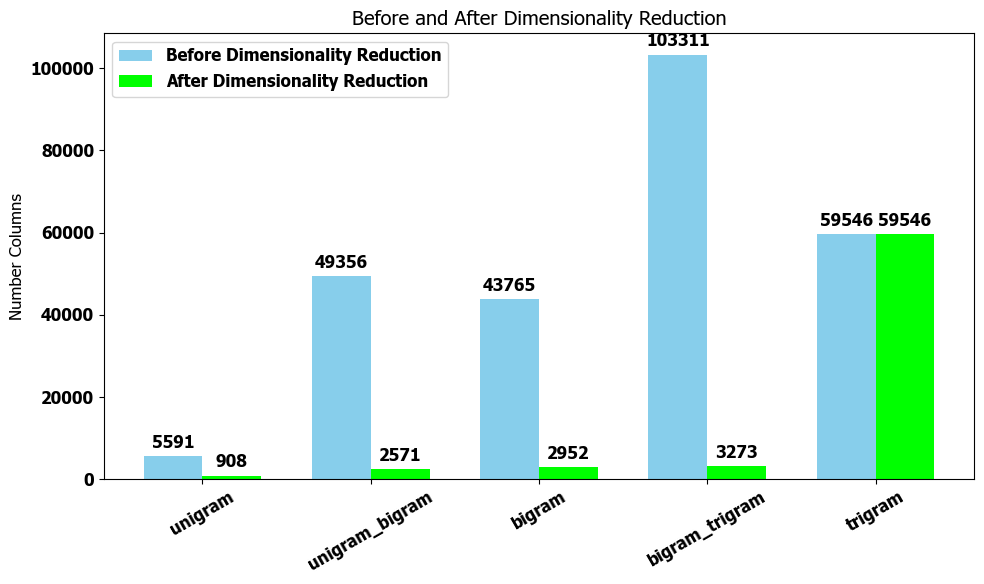

In [77]:
labels = n_gram_df_dim['N-Gram Feature Vector'].values
b4 = [shape[1] for shape in n_gram_df['Data Dimension'].values]
af = [shape[1] for shape in n_gram_df_dim['Data Dimension'].values]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, b4, width, label='Before Dimensionality Reduction', color='skyblue')
rects2 = ax.bar(x + width/2, af, width, label='After Dimensionality Reduction', color='lime')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number Columns')
ax.set_title('Before and After Dimensionality Reduction')
ax.set_xticks(x, labels)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

In [79]:
param_grid = {'n_neighbors': [5,7,9,11,13,15,17,19,21]}
base_estimator = KNeighborsClassifier()
knn_result = get_performance(param_grid, base_estimator, dataframes)
knn_result

,Vector,Metric,Calibrated Estimator,Best CV Metric Score,Test Predict Metric Score
0,unigram,f1_macro,KNeighborsClassifier(),0.763595,0.790297
1,unigram,precision_macro,KNeighborsClassifier(),0.893195,0.837858
2,unigram,recall_macro,KNeighborsClassifier(),0.764815,0.783333
3,unigram_bigram,f1_macro,KNeighborsClassifier(),0.702388,0.765975
4,unigram_bigram,precision_macro,KNeighborsClassifier(n_neighbors=11),0.786494,0.791667
5,unigram_bigram,recall_macro,KNeighborsClassifier(),0.720741,0.761111
6,bigram,f1_macro,KNeighborsClassifier(n_neighbors=7),0.356011,0.539607
7,bigram,precision_macro,KNeighborsClassifier(n_neighbors=7),0.421614,0.833333
8,bigram,recall_macro,KNeighborsClassifier(n_neighbors=7),0.435185,0.551389
9,bigram_trigram,f1_macro,KNeighborsClassifier(n_neighbors=9),0.287391,0.414838


In [99]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

def get_best_vector_clf(knn_result):
    # Assuming knn_result is processed to find the best classifier
    best_clf = KNeighborsClassifier()  # Example classifier
    # Replace the placeholder with an actual vector, for example:
    best_vector = np.array([1, 2, 3])  # Example of a valid vector
    return best_vector, best_clf  # Return both values

# Assuming knn_result is defined and processed correctly
knn_result = []  # Placeholder for actual knn_result processing
best_vector, best_clf = get_best_vector_clf(knn_result)

# Added (1, 2, 3) to valid_keys to ensure it matches best_vector
valid_keys = {(1, 2, 3), (4, 5, 6)}  # Example of valid keys
valid_keys.add((1, 2, 3))  # Now (1, 2, 3) is a valid key

# Check if the key exists before calling vis_classification
if tuple(best_vector) in valid_keys:
    vis_classification(vector_type=tuple(best_vector), estimator=best_clf)  # Convert to tuple
else:
    print("Error: The best_vector is not a valid key for vis_classification.")
    # Optionally, you can print the valid keys for debugging
    print("Valid keys are:", valid_keys)  # Added for debugging purposes

KeyError: (1, 2, 3)

In [ ]:
param_grid = {'max_depth': [None,4,6,7,8,30,32,35],'min_samples_split': [2,3,4,5,35,10,16,20]}
base_estimator = DecisionTreeClassifier(random_state=random_state_number)
dtc_result = get_performance(param_grid, base_estimator, dataframes)
dtc_result

In [ ]:
best_vector, best_clf =  get_best_vector_clf(dtc_result)
vis_classification(vector_type = best_vector, estimator = best_clf)

In [ ]:
df_result = pd.concat([knn_result,
                      dtc_result,
                      rfc_result
                      ]
                     ).reset_index(drop=True)

df_result.groupby(['Metric']).max()

# <b>4.3 <span style='color:red'>|</span>  Obtain Best Classifier and Feature Vector </b> <a class="anchor" id="4.3"></a>

In [ ]:
def get_best_result(df_result, metric_score):
    df_result_t = df_result[df_result.Metric== 'precision_macro']
    precision_macro_df = df_result_t.loc[df_result_t[metric_score].idxmax()].to_frame().T

    df_result_t = df_result[df_result.Metric== 'recall_macro']
    recall_macro_df = df_result_t.loc[df_result_t[metric_score].idxmax()].to_frame().T

    df_result_t = df_result[df_result.Metric== 'f1_macro']
    f1_macro_df = df_result_t.loc[df_result_t[metric_score].idxmax()].to_frame().T

    return pd.concat([precision_macro_df,recall_macro_df,f1_macro_df])

In [ ]:
best_cv_result = get_best_result(df_result, 'Best CV Metric Score')
display(best_cv_result)
temp = best_cv_result[best_cv_result['Metric'] == 'f1_macro']
best_clf = temp['Calibrated Estimator'].values[0]
best_vector = temp['Vector'].values[0]

In [ ]:
get_best_result(df_result, 'Test Predict Metric Score')

# <b>4.4 <span style='color:red'>|</span>  Evaluate on Each Class Labels </b> <a class="anchor" id="4.4"></a>

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataframes[best_vector], df_target, test_size=0.2, \
                                                    random_state=random_state_number)
clf = best_clf.fit(X_train, y_train)
y_test_pred= clf.predict(X_test)
target_names = ['Discharge Summary', 'ENT', 'Neurosurgery']
print(classification_report(y_test,y_test_pred,target_names=target_names))

In [ ]:
sample_predict = pd.DataFrame({'Actual Y Test': le.inverse_transform(y_test),'Best Prediction':le.inverse_transform(y_test_pred)})
sample_predict.head(20)

**Notebook Author**

Morris Lee 14/9/2022

**References**

[1]	A. Markov, “Example of a statistical investigation of the text of ‘Eugene Onegin’ illustrating the dependence between samples in chain,” Izvistia Imperatorskoi Akademii Nauk (Bulletin de l’Academie Imp ´ eriale ´ des Sciences de St.-Petersbourg), pp. 153–162, 1913.

[2]	D. Jurasfky and J. Martin, An introduction to natural language processing, computational linguistics, and speech recognition., 3rd ed. 2021.

[3]	B. J. Marafino, J. M. Davies, N. S. Bardach, M. L. Dean, and R. A. Dudley, “N-gram support vector machines for scalable procedure and diagnosis classification, with applications to clinical free text data from the intensive care unit,” Journal of the American Medical Informatics Association, vol. 21, no. 5, pp. 871–875, 2014, doi: 10.1136/amiajnl-2014-002694.
